# Dogs of New York

In [42]:
from sodapy import Socrata  # for getting NYC Open Data
import pandas as pd
import requests
import json
import csv
import geopandas as gpd
import matplotlib
import datetime

Download data from NYC Open Data and make into Pandas dataframe.

In [2]:
nyc_data_url = 'data.cityofnewyork.us'
nyc_data_set = "nu7n-tubp"
nyc_app_token = "I2gtjPD9w788AnMk32W8lmmL8" #don't share this
client = Socrata(nyc_data_url,nyc_app_token)

client.timeout = 60

all_dogs_dict = client.get_all(nyc_data_set)
all_dogs_df = pd.DataFrame.from_records(all_dogs_dict)


In [5]:
all_dogs_df.to_csv("all_nyc_dogs.csv",index=False) # use as backup

Some dogs are registered with invalid or outside-of-NYC zipcodes, so we need to get a list of only those definitively placeable in NYC. For that, we need a list of NYC zipcodes.

In [3]:
manhattan_zips = [str(zipcode) for zipcode in list(range(10001,10283))]
staten_zips = [str(zipcode) for zipcode in list(range(10301,10315))]
bronx_zips = [str(zipcode) for zipcode in list(range(10451,10476))]
queens_zips = [str(zipcode) for zipcode in list(range(11004,11110))] + [str(zipcode) for zipcode in list(range(11351,11698))]
brooklyn_zips = [str(zipcode) for zipcode in list(range(11201,11257))]
nyc_zips = manhattan_zips + staten_zips + bronx_zips + queens_zips + brooklyn_zips


In [91]:
all_dogs_nyc_df = all_dogs_df[all_dogs_df["zipcode"].isin(nyc_zips)].reset_index(drop=True)


Load ACS 5-year data on median incomes by ZCTA.

In [ ]:
### moved this to separate program so it didn't do an API call every time.
# census_api_key = "b08c2ad933f74f40428c15d03a91c23b7e53854d" #don't share this
# acs_median_income_variable = "B19013_001E"
# acs_base_url = "https://api.census.gov/data/2021/acs/acs5"
# acs_zipcode_income = []
# i = 0
# for zipcode in nyc_zips:
#     acs_url = "{acs_base_url}?get=NAME,{acs_variable}&for=zip%20code%20tabulation%20area:{zipcode}&key={census_api_key}"\
#     .format(acs_base_url = acs_base_url,acs_variable = acs_median_income_variable,census_api_key=census_api_key,\
#             zipcode=zipcode)
#     acs_results = requests.get(acs_url)
#     try:
#         acs_json = acs_results.json()
#     except requests.exceptions.JSONDecodeError:
#         pass
#     acs_dict = {key:value for key, value in zip(acs_json[0],acs_json[1])}
#     acs_dict.pop("NAME")
#     acs_zipcode_income.append(acs_dict)
# for item in acs_zipcode_income:
#     item["zipcode"] = item.pop("zip code tabulation area")
#     item["median_income"] = int(item.pop("B19013_001E"))

# with open("acs_zipcode_income.csv","w",newline="") as income_csv:
#     csv_writer = csv.writer(income_csv)
#     csv_writer.writerow(["zipcode","median_income"])
#     for dict in acs_zipcode_income:
#         csv_writer.writerow(dict.values())


In [92]:
nyc_zips_income = pd.read_csv("C:/workspace/nyc_dogs_project/acs_zipcode_income.csv", dtype={
    "zipcode": "string",
    "median_income": "int64"
})


ACS data is attached to ZCTAs, which aren't entirely analogous to zipcodes due to some zipcodes having no population. NYC created shapefiles of modified ZCTAs for mapping COVID data; these can be used for mapping ACS data and connecting it with the zipcodes of the dog licensing dataset.

In [93]:
shape_url = "https://data.cityofnewyork.us/api/geospatial/pri4-ifjk?date=20231107&accessType=DOWNLOAD&method=export&format=Shapefile"
zcta_shapes = gpd.read_file(shape_url)
nyc_zcta_shapes = zcta_shapes[["modzcta","pop_est","geometry"]].rename(columns={"modzcta": "zipcode"})


## Cleaning the dog licensing dataset

### Dealing with duplicates

Dogs recur in the dataset every time their license is renewed (whether due to expiration or replacement). Thus we need to deal with entries that are probable duplicates: dogs that share a name, gender, birth year, and breed.

In [94]:
print("Number of entries in dataset:",len(all_dogs_nyc_df))
print("Number of (seemingly) duplicate entries in dataset:",len(all_dogs_nyc_df)-len(all_dogs_nyc_df.drop_duplicates(subset=["animalname","animalgender","animalbirth","breedname","zipcode"])))

Number of entries in dataset: 506481
Number of (seemingly) duplicate entries in dataset: 241712


In [95]:
all_dogs_nyc_df_dupe_col = all_dogs_nyc_df.duplicated(subset=["animalname","animalgender","animalbirth","breedname","zipcode"])

In [96]:
all_dogs_nyc_df["dupe"] = all_dogs_nyc_df_dupe_col

However, since 24839 of those have an unknown breed, they may well *not* all be duplicates. Including these possible duplicates would affect the total number of dogs, but not the total number of any given breed. Additionally, it is unlikely that all 16 "duplicate" French Bulldogs with an unknown name that were born in 2020 and live in zipcode 10011 are the same dog, and likewise for the 13 "duplicate" Goldendoodles of unknown name with the same birthdate and zipcode. If we assume no more than two re-registrations per year of life for any given dog (already a generous estimation), we can retain more dogs in the dataset.

In [97]:
all_dogs_nyc_df_dupes = all_dogs_nyc_df[all_dogs_nyc_df["dupe"] == True]
print(all_dogs_nyc_df_dupes.groupby("breedname").size().sort_values(ascending=False))
#print(all_dogs_nyc_df_dupes[all_dogs_nyc_df_dupes["breedname"] == "Unknown"].groupby(["animalname","animalgender","animalbirth","zipcode"]).size().sort_values(ascending=False))
print(all_dogs_nyc_df_dupes.groupby(["zipcode","breedname","animalname","animalgender","animalbirth"]).size().sort_values(ascending=False))

breedname
Unknown                         24839
Yorkshire Terrier               15255
Shih Tzu                        14508
Chihuahua                       10714
Maltese                          8254
                                ...  
Small Munsterlander Pointer         1
Irish Water Spaniel                 1
Greek Shephard                      1
Grand Basset Griffon Vendeen        1
Otterhound                          1
Length: 322, dtype: int64
zipcode  breedname          animalname  animalgender  animalbirth
10011    French Bulldog     FRENCH      F             2017           18
                            UNKNOWN     F             2020           16
         Goldendoodle       UNKNOWN     M             2020           13
11204    Unknown            MAX         M             2008           12
10011    Dachshund          UNKNOWN     M             2019           12
                                                                     ..
10462    Shih Tzu           DUMBLEDORE  M       

In [98]:
all_dogs_nyc_df["licenseissueddate"] = pd.to_datetime(all_dogs_nyc_df["licenseissueddate"])
all_dogs_nyc_df["licenseexpireddate"] = pd.to_datetime(all_dogs_nyc_df["licenseexpireddate"])
all_dogs_nyc_df["licenseissueyear"] = all_dogs_nyc_df["licenseissueddate"].dt.year
all_dogs_nyc_df["licenseexpireyear"] = all_dogs_nyc_df["licenseexpireddate"].dt.year

In [99]:
all_dogs_nyc_df.head(8)

,animalname,animalgender,animalbirth,breedname,zipcode,licenseissueddate,licenseexpireddate,extract_year,dupe,licenseissueyear,licenseexpireyear
0,PAIGE,F,2014,American Pit Bull Mix / Pit Bull Mix,10035,2014-09-12,2017-09-12,2016,False,2014,2017.0
1,YOGI,M,2010,Boxer,10465,2014-09-12,2017-10-02,2016,False,2014,2017.0
2,ALI,M,2014,Basenji,10013,2014-09-12,2019-09-12,2016,False,2014,2019.0
3,QUEEN,F,2013,Akita Crossbreed,10013,2014-09-12,2017-09-12,2016,False,2014,2017.0
4,LOLA,F,2009,Maltese,10028,2014-09-12,2017-10-09,2016,False,2014,2017.0
5,IAN,M,2006,Unknown,10013,2014-09-12,2019-10-30,2016,False,2014,2019.0
6,BUDDY,M,2008,Unknown,10025,2014-09-12,2017-10-20,2016,False,2014,2017.0
7,CHEWBACCA,F,2012,Labrador Retriever Crossbreed,10013,2014-09-12,2019-10-01,2016,False,2014,2019.0


We definitely have to drop dogs that are the same in *all* respects (including date of license issue and expiry) except extract year, since we have to assume that these are true repeats caused by extraction in multiple years (whether they are or not).
**N.B. If the extract year is the *same*, then we should be able to consider them *different* dogs; I still need to account for this. But this turned out not to be true: test case dog named 'GALINDA'.**

In [100]:
all_dogs_nyc_df.drop_duplicates(subset=["animalname","animalgender","animalbirth","breedname","zipcode","licenseissueddate","licenseexpireddate","licenseissueyear","licenseexpireyear"],inplace=True)

In [101]:
print(all_dogs_nyc_df["licenseissueyear"].dtype,all_dogs_nyc_df["licenseexpireyear"].dtype)

int32 float64


In [102]:
all_dogs_nyc_df[all_dogs_nyc_df["licenseexpireyear"].isnull() == True]

,animalname,animalgender,animalbirth,breedname,zipcode,licenseissueddate,licenseexpireddate,extract_year,dupe,licenseissueyear,licenseexpireyear
341926,MERIDA,F,2018,Poodle Crossbreed,11040,2019-02-16,NaT,2022,False,2019,NaN
344095,BELLA,F,2018,Dachshund,11223,2019-03-09,NaT,2022,False,2019,NaN
344719,CHEWY,M,2018,West High White Terrier,11224,2019-03-15,NaT,2022,False,2019,NaN
346541,BRUNO,F,2019,Bulldog,11220,2019-04-01,NaT,2022,False,2019,NaN
347132,UNKNOWED,M,2019,Poodle,10305,2019-04-06,NaT,2022,False,2019,NaN
348946,NAME NOT PROVIDED,F,2018,Puggle,11104,2019-04-21,NaT,2022,True,2019,NaN
350216,UNKNOWED,F,2019,Goldendoodle,11211,2019-05-03,NaT,2022,False,2019,NaN
352627,UNKNOWN,F,2018,Affenpinscher,11565,2019-05-26,NaT,2022,False,2019,NaN
354305,HEI,M,2019,Pug,11590,2019-06-11,NaT,2022,False,2019,NaN
366346,NAME NOT PROVIDED,M,2019,Beagle,11354,2019-10-02,NaT,2022,True,2019,NaN


In [103]:
all_dogs_nyc_df.groupby("licenseexpireyear").size()

licenseexpireyear
2016.0    28891
2017.0    70986
2018.0    69854
2019.0    71087
2020.0    71010
2021.0    68490
2022.0    65059
2023.0    10516
2024.0     5107
2025.0     3521
2026.0     3280
2027.0      127
2028.0       25
2029.0       22
2030.0       27
2031.0       15
2032.0        2
2034.0        1
2039.0        1
dtype: int64

In [104]:
all_dogs_nyc_df_dupes = all_dogs_nyc_df[all_dogs_nyc_df["dupe"] == True]
print(all_dogs_nyc_df_dupes.groupby("breedname").size().sort_values(ascending=False))
#print(all_dogs_nyc_df_dupes[all_dogs_nyc_df_dupes["breedname"] == "Unknown"].groupby(["animalname","animalgender","animalbirth","zipcode"]).size().sort_values(ascending=False))
print(all_dogs_nyc_df_dupes.groupby(["zipcode","breedname","animalname","animalgender","animalbirth"]).size().sort_values(ascending=False))

breedname
Unknown                         24837
Yorkshire Terrier               12897
Shih Tzu                        12416
Chihuahua                        9270
Maltese                          7105
                                ...  
Grand Basset Griffon Vendeen        1
Otterhound                          1
Greek Shephard                      1
Peruvian Inca Orchid                1
Jagdterrier                         1
Length: 316, dtype: int64
zipcode  breedname                             animalname  animalgender  animalbirth
10011    French Bulldog                        FRENCH      F             2017           17
11377    Unknown                               MAX         M             2010           12
11204    Unknown                               MAX         M             2008           12
10306    Unknown                               MAX         M             2011           12
11215    Maltese                               DAISY       F             2014           11
      

In [130]:
all_dogs_nyc_df[all_dogs_nyc_df.dupe == True].groupby(["animalname","animalgender","animalbirth","breedname","zipcode","licenseissueyear","licenseexpireyear","extract_year"]).size().sort_values(ascending=False)

animalname  animalgender  animalbirth  breedname                           zipcode  licenseissueyear  licenseexpireyear  extract_year
UNKNOWN     M             2019         Dachshund                           10011    2019              2020.0             2022            6
            F             2020         French Bulldog                      10011    2020              2021.0             2022            5
            M             2021         Miniature Australian Shepherd       10014    2021              2022.0             2022            5
FRENCH      F             2017         French Bulldog                      10011    2018              2019.0             2018            5
UNKNOWN     M             2019         French Bulldog                      10009    2020              2021.0             2022            5
                                                                                                                                        ..
GINO        M             2010  

In [203]:
all_dogs_repeated_order = all_dogs_nyc_df.sort_values(by=["animalname","animalgender","animalbirth","breedname","zipcode"]).reset_index().rename(columns={"index": "old_index"})
repeat_index_list = []
for rownum in range(len(all_dogs_repeated_order["old_index"])):
    if (all_dogs_repeated_order.dupe.iloc[rownum] == True) and ((all_dogs_repeated_order.licenseissueyear.iloc[rownum] == all_dogs_repeated_order.licenseexpireyear.iloc[rownum-1]) or (all_dogs_repeated_order.licenseissueyear.iloc[rownum] == all_dogs_repeated_order.licenseexpireyear.iloc[rownum-1]+1)or (all_dogs_repeated_order.licenseissueyear.iloc[rownum] == all_dogs_repeated_order.licenseexpireyear.iloc[rownum-1]-1)):
        #repeat_index_list.append([rownum, all_dogs_repeated_order.old_index.iloc[rownum]])
        repeat_index_list.append(rownum)
    else:
        repeat_index_list.append(None)
repeat_index_list


[None,
 1,
 2,
 None,
 4,
 5,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 46,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 77,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 120,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 N

In [204]:
true_dupe = pd.Series(repeat_index_list)
true_dupe

0              NaN
1              1.0
2              2.0
3              NaN
4              4.0
            ...   
468047         NaN
468048    468048.0
468049         NaN
468050         NaN
468051    468051.0
Length: 468052, dtype: float64

In [205]:
all_dogs_repeated_order["true_dupe"] = true_dupe.apply(lambda x: "" if pd.isnull(x) else "dupe")

In [206]:
all_dogs_repeated_order

,old_index,animalname,animalgender,animalbirth,breedname,zipcode,licenseissueddate,licenseexpireddate,extract_year,dupe,licenseissueyear,licenseexpireyear,true_dupe
0,74809,'RUSTY,M,2014,Cavalier King Charles Spaniel,11378,2016-07-01,2017-07-11,2016,False,2016,2017.0,
1,160683,'RUSTY,M,2014,Cavalier King Charles Spaniel,11378,2017-08-27,2018-07-11,2017,True,2017,2018.0,dupe
2,225397,'RUSTY,M,2014,Cavalier King Charles Spaniel,11378,2018-07-16,2019-07-11,2018,True,2018,2019.0,dupe
3,75838,(LEELA)LILA,F,2005,German Shepherd Crossbreed,10009,2016-07-07,2017-07-30,2016,False,2016,2017.0,
4,146910,(LEELA)LILA,F,2005,German Shepherd Crossbreed,10009,2017-06-29,2018-07-30,2017,True,2017,2018.0,dupe
...,...,...,...,...,...,...,...,...,...,...,...,...,...
468047,421946,true,M,2018,"Jindo Dog, Korea",11217,2020-08-21,2021-08-21,2022,False,2020,2021.0,
468048,422928,true,M,2018,"Jindo Dog, Korea",11217,2020-07-30,2021-07-30,2022,True,2020,2021.0,dupe
468049,410659,true,M,2020,German Shepherd Dog,11205,2020-05-18,2021-05-18,2022,False,2020,2021.0,
468050,80351,ÔISHI,M,2014,American Staffordshire Terrier,10309,2016-07-23,2021-09-21,2016,False,2016,2021.0,


In [207]:
all_dogs_repeated_order[(all_dogs_repeated_order.dupe == True) & (all_dogs_repeated_order.true_dupe == "")]

,old_index,animalname,animalgender,animalbirth,breedname,zipcode,licenseissueddate,licenseexpireddate,extract_year,dupe,licenseissueyear,licenseexpireyear,true_dupe
372,391039,A,M,2019,Yorkshire Terrier,11103,2020-08-06,2021-08-06,2022,True,2020,2021.0,
596,285461,ABBEY,F,2013,Brussels Griffon,10001,2020-02-23,2020-06-15,2022,True,2020,2020.0,
845,183096,ABBY,F,2009,"Schnauzer, Miniature",11354,2017-12-11,2019-02-06,2017,True,2017,2019.0,
884,223008,ABBY,F,2010,Greyhound,10013,2018-07-05,2020-01-26,2018,True,2018,2020.0,
893,279266,ABBY,F,2010,"Schnauzer, Miniature",10307,2020-10-17,2021-05-03,2022,True,2020,2021.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
467620,333253,ZSERBO,M,2013,Silky Terrier,11249,2020-10-25,2021-09-09,2022,True,2020,2021.0,
467624,237000,ZSOZSO,M,2012,Chihuahua,11219,2018-09-11,2023-07-16,2018,True,2018,2023.0,
467737,322864,ZUKI,F,2016,Labradoodle,10010,2020-06-25,2020-10-29,2022,True,2020,2020.0,
467885,277881,ZURI,F,2007,"Collie, Border",10027,2020-05-27,2021-01-28,2022,True,2020,2021.0,


In [248]:
all_dogs_nyc_no_dupes = all_dogs_repeated_order[all_dogs_repeated_order["true_dupe"] == ""].sort_values("old_index").reset_index(drop=True)
all_dogs_nyc_no_dupes

,old_index,animalname,animalgender,animalbirth,breedname,zipcode,licenseissueddate,licenseexpireddate,extract_year,dupe,licenseissueyear,licenseexpireyear,true_dupe
0,0,PAIGE,F,2014,American Pit Bull Mix / Pit Bull Mix,10035,2014-09-12,2017-09-12,2016,False,2014,2017.0,
1,1,YOGI,M,2010,Boxer,10465,2014-09-12,2017-10-02,2016,False,2014,2017.0,
2,2,ALI,M,2014,Basenji,10013,2014-09-12,2019-09-12,2016,False,2014,2019.0,
3,3,QUEEN,F,2013,Akita Crossbreed,10013,2014-09-12,2017-09-12,2016,False,2014,2017.0,
4,4,LOLA,F,2009,Maltese,10028,2014-09-12,2017-10-09,2016,False,2014,2017.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
269269,506434,BELLA,F,2010,MIXED,10314,2020-01-23,2021-02-20,2022,False,2020,2021.0,
269270,506443,SUKI,F,2008,Not Provided,10463,2020-01-23,2021-03-16,2022,False,2020,2021.0,
269271,506453,KILLIAN,M,2019,Not Provided,11226,2020-01-23,2021-01-23,2022,False,2020,2021.0,
269272,506454,FINN,M,2018,Not Provided,11218,2020-01-23,2021-01-23,2022,False,2020,2021.0,


In [288]:
print(all_dogs_nyc_no_dupes.groupby(["zipcode","breedname","animalname","animalgender","animalbirth"]).size().sort_values(ascending=False))
print("#####")
print(all_dogs_nyc_no_dupes.groupby(["zipcode","breedname","animalname","animalgender","animalbirth"]).size().reset_index().rename(columns={0: "size"}).sort_values(by=["size","animalbirth"],ascending=[False,False]))


zipcode  breedname                      animalname  animalgender  animalbirth
10023    Labrador Retriever Crossbreed  DAIZY       F             2017           4
10464    Schnauzer, Miniature           CANDY       F             2009           4
10470    Alaskan Malamute               TOBY        M             2015           4
11223    German Shepherd Dog            REX         M             2013           4
10306    Unknown                        CODY        M             2010           4
                                                                                ..
10162    Labrador Retriever Crossbreed  STELLA      F             2020           1
         Maltese                        MUFFIN      M             2019           1
         Maltese Crossbreed             KIKI        F             2014           1
         Maltipoo                       CASEY       M             2020           1
11697    Yorkshire Terrier              LOLA        F             2020           1
Length: 2

In [258]:
#print(all_dogs_nyc_no_dupes.groupby(["zipcode","breedname"]).size())
all_dogs_nyc_no_dupes.groupby(["zipcode","breedname"]).old_index.count().reset_index().sort_values(["zipcode","old_index"],ascending=[True,False])

,zipcode,breedname,old_index
170,10001,Unknown,120
72,10001,French Bulldog,87
183,10001,Yorkshire Terrier,78
47,10001,Chihuahua,73
122,10001,Pomeranian,68
...,...,...,...
27515,11697,Sealyham Terrier,1
27516,11697,Shiba Inu,1
27518,11697,Shih Tzu Crossbreed,1
27519,11697,Staffordshire Bull Terrier,1


**Still need to fix the above duplication-dropping by looking carefully at dogs born in recent years.**
**May want to give dogs a unique ID *instead* of dropping duplicates.**

### Dealing with weird license expiry dates

Dog licenses can be renewed for up to five years. However, some expiry dates in the dataset are more than five years past the latest extraction date. 

In [270]:
all_dogs_nyc_no_dupes[all_dogs_nyc_no_dupes["licenseexpireyear"] > all_dogs_nyc_no_dupes["licenseissueyear"] + 6].groupby(["licenseexpireyear","licenseissueyear"]).size()

licenseexpireyear  licenseissueyear
2024.0             2017                 1
2025.0             2018                 2
2026.0             2018                 1
                   2019                 9
2027.0             2018                 2
                   2019                 3
                   2020                 3
2028.0             2018                 3
                   2019                 3
                   2020                 5
                   2021                 9
2029.0             2019                11
                   2020                 4
                   2021                 6
2030.0             2019                 2
                   2020                10
                   2021                11
2031.0             2019                 1
                   2020                 1
                   2021                 9
2032.0             2019                 1
                   2020                 1
2034.0             2019                 

## Mapping the Data

Text(0.5, 1.0, 'Median Income in NYC, by zip code')

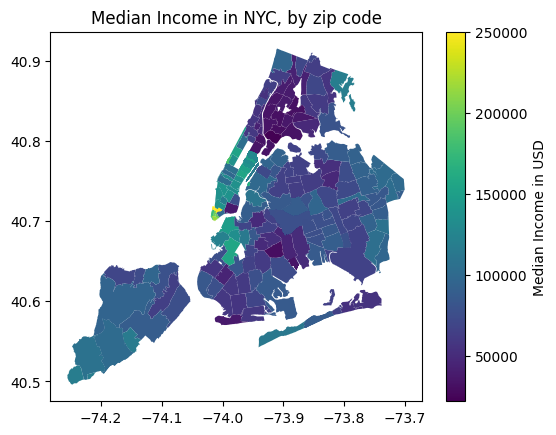

In [282]:
nyc_zips_income_geoms = nyc_zcta_shapes.merge(nyc_zips_income, how="inner")
nyc_zips_income_geoms.plot(column="median_income",legend=True,legend_kwds={"label": "Median Income in USD"}).set_title("Median Income in NYC, by zip code")


In [272]:
all_dogs_zip_income = pd.merge(all_dogs_nyc_no_dupes,nyc_zips_income,how="left")
breeds_by_zip = all_dogs_zip_income.groupby(["zipcode","median_income","breedname"]).animalbirth.count().reset_index().rename(columns={"animalbirth": "count"})
breeds_by_zip_geoms = nyc_zcta_shapes.merge(breeds_by_zip,how="outer")
